In [1]:
# 구글 드라이브 마운트 
from google.colab import drive
drive.mount('/content/drive/')

KeyboardInterrupt: ignored

In [ ]:
# mallet 다운로드
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
# konlpy 설치
!pip install konlpy

# worldcloud 설치
!pip install wordcloud

# 데이터 전처리

In [ ]:
# 러닝타임을 줄이기 위해 전처리완료된 파일을 사용할 경우, 박스 아래의 코드를 실행하지 않고 해당 박스만 실행하여 전처리 완료 
# .csv로 테스트
import pandas as pd
folder = '/content/drive/MyDrive/빅데이터예측분석_5조/개발자료/SNS_토픽모델링/211201'
result = pd.read_csv(folder + '/result_일과직업.csv')

In [ ]:
import pandas as pd
from pandas import DataFrame
import json, os

#파일이 여러 개 일때, 하나의 데이터 프레임으로 만들기 파일명이 파일명01.json,파일명02.json...일 때   
date=['01']    
folder = '/content/drive/MyDrive/빅데이터예측분석_5조/개발자료/SNS_토픽모델링/211201'
result = DataFrame()
for i in date:
    print(i)
    fileName = folder + '/test_data' + str(i) + '.json'
    isExist = os.path.isfile(fileName)
    if isExist : 
      try : 
        data = json.load(open(fileName))
        
        df = DataFrame(data["data"])['header'] # data에 있는 모든 header 
        for idx in df.index :
          # 참가자 정보 
          participantsInfo = df.iloc[idx]['participantsInfo']
          pID = DataFrame(participantsInfo)['participantID']
          age = DataFrame(participantsInfo)['age']
          gender = DataFrame(participantsInfo)['gender']
          residentialProvince = DataFrame(participantsInfo)['residentialProvince']
          
          uInfo = pd.concat([pID, age, gender,residentialProvince], ignore_index=True,axis = 1)
          uInfo.columns = ["participantID", "age", "gender", "residentialProvince"]

          # 대화 내용
          df2 = DataFrame(data["data"])['body'][idx]
          ut = DataFrame(df2)['utterance']
          date = DataFrame(df2)['date']

          uiPID = DataFrame(df2)['participantID']
          utInfo = pd.concat([uiPID, ut, date], ignore_index=True,axis = 1)
          utInfo.columns = ['participantID', 'utterance', 'date']

          merged = pd.merge(uInfo, utInfo ,how="right", on="participantID")
          result = pd.concat([result, merged], ignore_index=True,axis = 0)
        
        # result.columns = ["pID", "age", "gender", "residentialProvince", "utterance" 'date']
      except Exception as e:
        print(e)
    else :
      print("File Not Exist: ", fileName)
      break
result

# csv 추출
result.to_csv('result.csv', sep=',', na_rep='NaN')



01


# 조건에 부합하는 대화 내용에서 명사 추출

In [ ]:
def getList(key, value) :
  return result.loc[result[key] == value]

# 연령대 별 결과물 추출
list = getList('age', '20대')

# 성별 별 결과물 추출
# list = getList('gender', '남성')

# 지역 별 결과물 추출
# list = getList('residentialProvince', '부산광역시')

# 복합 조건 
# list = result.loc[(result['residentialProvince'] == '부산광역시') & (result['gender'] == '여성')] 

from konlpy.tag import Okt
okt = Okt()
words = []
for i in range(len(list)) :
  ut = list['utterance'].iloc[i]
  n = okt.nouns(ut) # 명사 단위 추출 

  # print(ut, '=====>',n)
  words.append(n)  

  # 빈 아이템 삭제 필요 

In [ ]:
words

[['한국', '사', '드꺼운', '마스크', '개'],
 ['땜', '일케', '심각', '안해'],
 ['당일', '당일', '폐쇠'],
 ['어젠', '엇그제', '우한', '도시', '폐쇠'],
 ['어제', '개', '도시', '확대', '폐쇠'],
 ['오늘', '상해', '관광지', '폐쇠'],
 ['긴급'],
 ['상해', '관광', '어늘', '긴급'],
 ['발표', '된거'],
 [],
 ['기차', '지하철'],
 ['뱅기'],
 ['기침', '걸'],
 ['옮는데'],
 ['공기', '침'],
 ['대박'],
 ['아예', '안밖못'],
 ['미가', '능', '사람', '어케'],
 ['또', '한국', '여행', '사람'],
 ['한국', '사람', '곳', '또', '또'],
 ['만', '한국', '보고'],
 ['여'],
 [],
 ['어제', '서비스', '차원'],
 [],
 [],
 [],
 [],
 ['주말', '엇어'],
 ['고생'],
 ['엉엉'],
 [],
 ['얘', '안', '급', '정도', '비속어', '알'],
 [],
 ['진짜', '가대', '박아'],
 ['학생', '거조', '아하'],
 ['오늘', '수업', '남자', '애', '내일'],
 ['가주', '소아', '너', '간다'],
 ['끼리'],
 ['진짜', '주소'],
 ['진짜'],
 ['서지', '끼리', '막'],
 [],
 ['대가리', '박아'],
 ['아숩다'],
 ['첨부', '터', '대가리'],
 [],
 [],
 ['완전', '애'],
 ['교사', '가격', '반응'],
 ['알', '똑바로', '것']]

In [ ]:
# LDA 모델
import gensim, os
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

id2word = corpora.Dictionary(words)
id2word.filter_extremes(no_below = 1) #20회 이하로 등장한 단어는 삭제
texts = words

corpus=[id2word.doc2bow(text) for text in texts]

ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

# 토픽별 일관성 점수 계산하여 가장 좋은 토픽 수의 모델 찾기

In [ ]:

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()


def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=2):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=words, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=4, limit=21, step=2)


KeyboardInterrupt: ignored

In [ ]:
limit=21; start=4; step=2;
x = range(start, limit, step)
topic_num = 0
count = 0
max_coherence = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", cv)
    coherence = cv
    if coherence >= max_coherence:
        max_coherence = coherence
        topic_num = m
        model_list_num = count   
    count = count+1

        
# Select the model and print the topics
optimal_model = model_list[model_list_num]
model_topics = optimal_model.show_topics(formatted=False)
#print(optimal_model.print_topics(num_words=10))

Num Topics = 4  has Coherence Value of 0.7923684456397492
Num Topics = 6  has Coherence Value of 0.7544151999737972
Num Topics = 8  has Coherence Value of 0.744853961049716
Num Topics = 10  has Coherence Value of 0.7344126922919546
Num Topics = 12  has Coherence Value of 0.7204341666654631
Num Topics = 14  has Coherence Value of 0.7107238907065149
Num Topics = 16  has Coherence Value of 0.7021090388966431
Num Topics = 18  has Coherence Value of 0.6883052273973249
Num Topics = 20  has Coherence Value of 0.6941387030873936


In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    #ldamodel[corpus]: lda_model에 corpus를 넣어 각 토픽 당 확률을 알 수 있음
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num,topn=10)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    sent_topics_df = pd.concat([sent_topics_df], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=words)

# Format
df_topic_tweet = df_topic_sents_keywords.reset_index()
# df_topic_tweet.columns = ["participantID", "age", "gender", "residentialProvince", "utterance" 'date']
df_topic_tweet

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)


topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.sort_index(inplace=True)

topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

lda_inform = pd.concat([sent_topics_sorteddf_mallet,topic_counts, topic_contribution], axis=1)
lda_inform.columns=['Dominant_Topic', "Topic_Perc_Contrib","Keywords","Topic_Counts", "Topic_Contribution"]


lda_inform.to_csv ("lda_inform.csv", index = None)
lda_inform

df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'] +1
df_topic_tweet.Dominant_Topic = df_topic_tweet.Dominant_Topic.astype(str)
df_topic_tweet['Dominant_Topic'] =df_topic_tweet['Dominant_Topic'].str.split('.').str[0]



# 토픽 별 word cloud

In [ ]:
#토픽별 트윗 저장
for i in range(1,topic_num+1):
    globals()['df_{}'.format(i)]=df_topic_tweet.loc[df_topic_tweet.Dominant_Topic==str(i)]
    globals()['df_{}'.format(i)].sort_values('Perc_Contribution',ascending=False,inplace = True)
    globals()['df_{}'.format(i)].to_csv ("topic("+str(i)+")_tweet.csv", index = None)

df_1

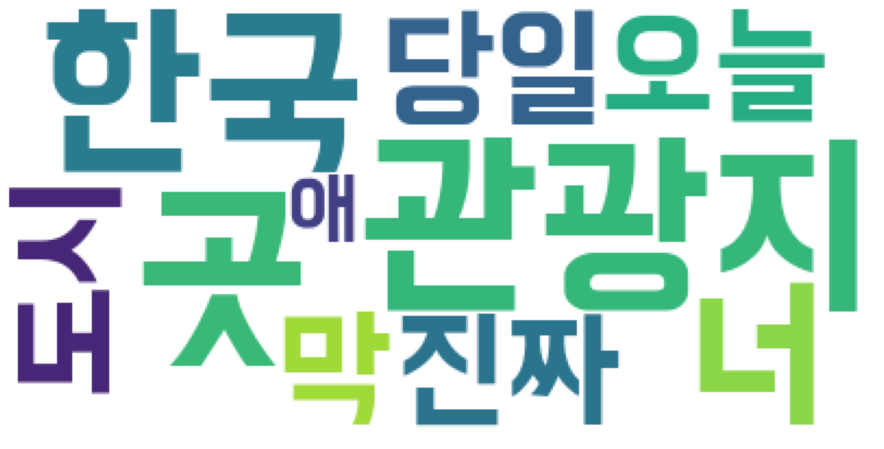

<Figure size 432x288 with 0 Axes>

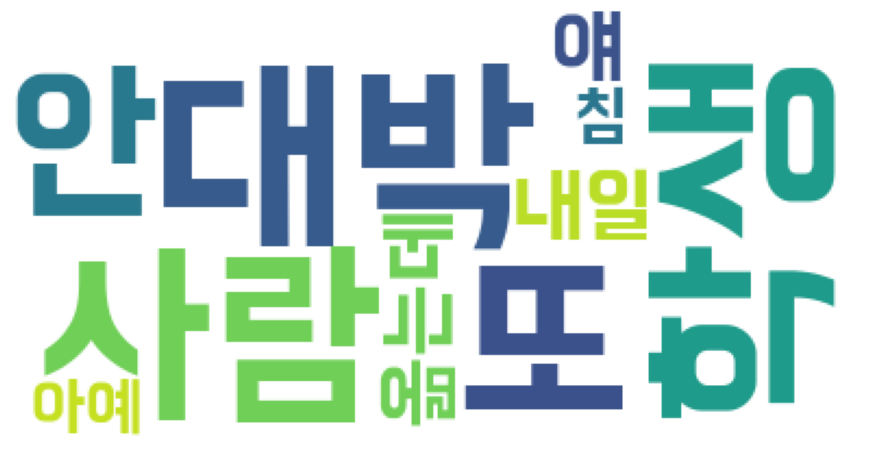

<Figure size 432x288 with 0 Axes>

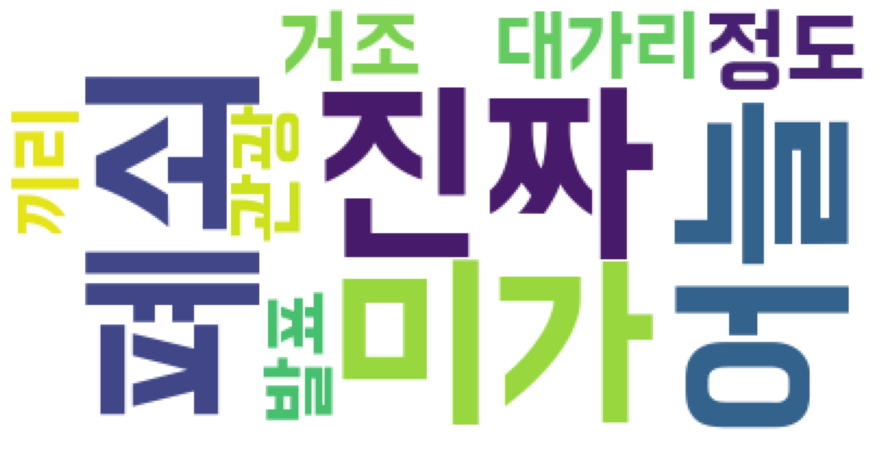

<Figure size 432x288 with 0 Axes>

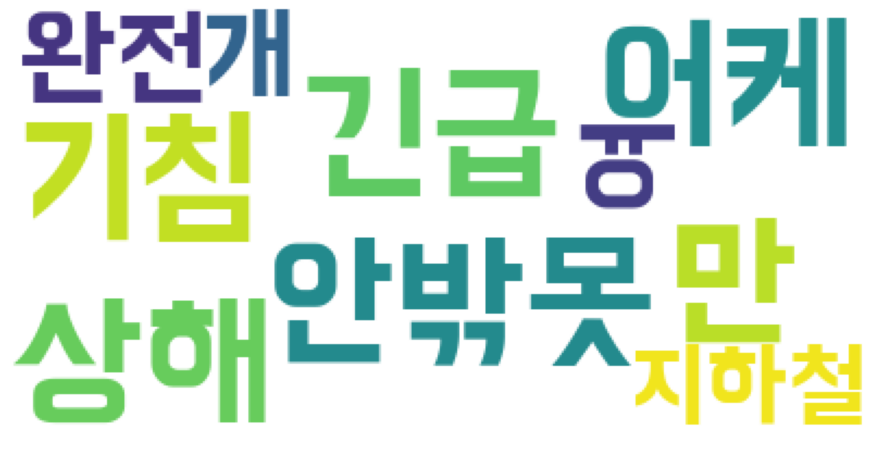

<Figure size 432x288 with 0 Axes>

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def flatten(l):
    flatList=[]
    for elem in l:
        if type(elem) == type(list):
            for e in elem:
                flatList.append(e)
        else:
            flatList.append(elem)
    return flatList


for i in range(1,topic_num+1):
    data_list = globals()['df_{}'.format(i)].Topic_Keywords.values.tolist()
    data_word=[]
    
    for j in range(len(data_list)):
        try:
            data_word.append(okt.nouns(data_list[j]))
        except Exception as e:
            continue       
    data_word=flatten(data_word)

    dw = []
    for x in data_word :
      for y in x :
        if not y.isdigit():
          dw.append(y)

    # data_word=[x for x in data_word if not x.isdigit()]
   
    freq=pd.Series(dw).value_counts().head(50)
    freq=dict(freq)
    
    wordcloud = WordCloud(font_path=folder +"/BMHANNA_11yrs_ttf.ttf",
             relative_scaling = 0.2,
             background_color = 'white').generate_from_frequencies(freq)
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

    plt.savefig("/topic("+str(i)+")wordcloud.png")